In [468]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [469]:
# Utility Methods

def filter_columns(dataframe: pd.DataFrame, dtype, exclude_columns=None):
    """ Helper method to select DataFrame columns by dtype
    and select columns to drop. """
    if exclude_columns is None:
        exclude_columns = []
    return [
        col for col in dataframe.select_dtypes(include=[dtype]).columns
        if col not in exclude_columns
    ]

In [482]:
class Plotter:
    def __init__(self, csv):
        self.dataframe = pd.read_csv(csv)
       
    # ------  CSV  F I L E S  ------ #  ^
    
        # failure_data
        # reformatted_data
        # pre_transform_data     -->     imputed_data
        # transformed_failure_data

    # --------- Utility Methods ---------- #
    
    def _create_subplots(self, num_plots, cols=3, subplot_size=(4, 4)):
        """Helper method to handle subplot creation with dynamic columns."""
        # Adjust cols to be the smaller value out of specified cols & num_plots
        cols = min(cols, num_plots)
        # Calculate the number of rows needed based on the number of columns
        rows = (num_plots // cols) + (num_plots % cols > 0)
        # Set the figure size based on the number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=(subplot_size[0] * cols, subplot_size[1] * rows))
    
        # Flatten axes if there's more than one, else convert it to a list
        if num_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
    
        # Hide any extra axes
        for ax in axes[num_plots:]:
            ax.set_visible(False)
    
        # Return rows and cols to maintain compatibility with existing calls
        self.fig = fig
        self.axes = axes
        return rows, cols

    # General multi-use line plot method
    def plot_line_chart(self, ax, x_values, y_values, title="Line Chart", group_columns=None, x_label=None, y_label=None):
        """
        Generic line plot method to visualise data, with optional support for grouping.

        Parameters:
            ax (matplotlib.axes._subplots.AxesSubplot): The axes on which to plot the line chart.
            x_values (pd.Index or array-like): The values to plot on the x-axis.
            y_values (pd.Series or dict): The values to plot on the y-axis. Can be a single series or a dictionary for multiple groups.
            title (str, optional): Title for the plot. Default is "Line Chart".
            group_columns (list, optional): List of group labels for plotting multiple lines.
            x_label (str, optional): Label for the x-axis. Default is None, which uses the x_values label.
            y_label (str, optional): Label for the y-axis. Default is None, which uses the y_values label.
        """
        if group_columns is not None:
            # Plotting multiple lines for each group
            for group in group_columns:
                ax.plot(
                    x_values,
                    y_values[group],
                    marker='o',
                    linestyle='-',
                    label=f'{group}'
                )
            ax.legend(title="legend")
        else:
            # Plotting a single line
            ax.plot(
                x_values,
                y_values,
                marker='o',
                linestyle='-',
                color='red'
            )
        ax.set_xticks(range(len(x_values)))
        ax.set_xticklabels(x_values, rotation=45, ha='right')
        ax.set_title(title)
        ax.set_xlabel(x_label if x_label else str(x_values))
        ax.set_ylabel(y_label if y_label else str(y_values))
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    def auto_bin_width(self, data, num_bins=25):
        """
        Calculate the bin width for a histogram using a custom approach with a specified number of bins,
        rounding to the nearest significant figure (order of magnitude).
        
        Parameters:
        - data (array-like): The data for which to calculate the bin width.
        - num_bins (int, optional): The number of bins to use for the calculation. Default is 36.
        
        Returns:
        - float: The computed bin width.
        """
        data = np.asarray(data)
        n = len(data)
    
        if n < 2:
            raise ValueError("Data must contain at least two data points.")
        
        # Use the specified number of bins
        data_range = np.max(data) - np.min(data)

        print(f"\nData range: {data_range}")
    
        # Calculate bin width
        bin_width = data_range / num_bins

        print(f"Initial bin width: {bin_width}")
    
        # Round the bin width to the nearest significant figure
        if bin_width == 0:
            raise ValueError("Bin width cannot be 0")

        # Determine the order of magnitude of the value
        order_of_magnitude = 10 ** (np.floor(np.log10(abs(bin_width))))
        # Round to the nearest significant figure
        rounded_bin_width = round(bin_width / order_of_magnitude) * order_of_magnitude

        # If rounding results in zero, return a small but non-zero value
        if rounded_bin_width == 0:
            rounded_bin_width = bin_width

        # Remove trailing .0 if the value is an integer
        if rounded_bin_width.is_integer():
            rounded_bin_width = int(rounded_bin_width)

        print(f"Rounded bin width: {rounded_bin_width}")
    
        return rounded_bin_width
    
    def failure_rate_analysis(self, dataframe, selected_column, target_column, group_column=None):
        """
        Create subplots of line charts using selected columns and target columns.
    
        Parameters:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            selected_column (list): List of machine setting columns (e.g., ['Torque [Nm]', 'Rotational speed [rpm]']).
            target_column (list): List of failure type columns (e.g., ['Machine failure', 'HDF']).
            group_column (str, optional): The column to group by (e.g., 'Type').
        """
        num_plots = len(selected_column)
        rows, cols = self._create_subplots(num_plots=num_plots, cols=3, subplot_size=(6, 4))
        axes = self.axes
    
        for idx, setting in enumerate(selected_column):
            # Calculate bin width using the auto_bin_width method
            bin_width = self.auto_bin_width(dataframe[setting])
    
            # Creating bins with the calculated width starting from the minimum value of the data
            min_value = dataframe[setting].min()
            dataframe['Selected Bin'] = pd.cut(
                dataframe[setting],
                bins=np.arange(min_value, dataframe[setting].max() + bin_width, bin_width).astype(int) if isinstance(bin_width, int) else np.arange(min_value, dataframe[setting].max() + bin_width, bin_width),
                right=False  # Ensures the bins are left-closed, right-open
            )
    
            # Group by 'Selected Bin' and 'target_column' and calculate failure rate for each type
            grouped = dataframe.groupby(['Selected Bin'])[target_column].agg(['sum', 'size'])
            failure_rates = {}
            for failure in target_column:
                failure_rates[failure] = (grouped[(failure, 'sum')] / grouped[(failure, 'size')]) * 100
    
            # Plotting the failure rate for each failure type
            self.plot_line_chart(
                ax=axes[idx],
                x_values=failure_rates[target_column[0]].index.astype(str),
                y_values=failure_rates,
                title=f'Failure Rate Analysis for {setting}',
                group_columns=target_column,
                x_label=f'{setting} Bins',
                y_label='Failure Rate (%)'
            )
    
            # Remove 'Selected Bin' column after analysis
            dataframe.drop(columns=['Selected Bin'], inplace=True)
    
        plt.tight_layout()
        plt.show()

In [483]:
plotter = Plotter('pre_transform_data.csv')


Data range: 72.8
Initial bin width: 2.912
Rounded bin width: 3

Data range: 1718
Initial bin width: 68.72
Rounded bin width: 70

Data range: 253.0
Initial bin width: 10.12
Rounded bin width: 10

Data range: 8.100000000000023
Initial bin width: 0.3240000000000009
Rounded bin width: 0.30000000000000004

Data range: 9.199999999999989
Initial bin width: 0.36799999999999955
Rounded bin width: 0.4


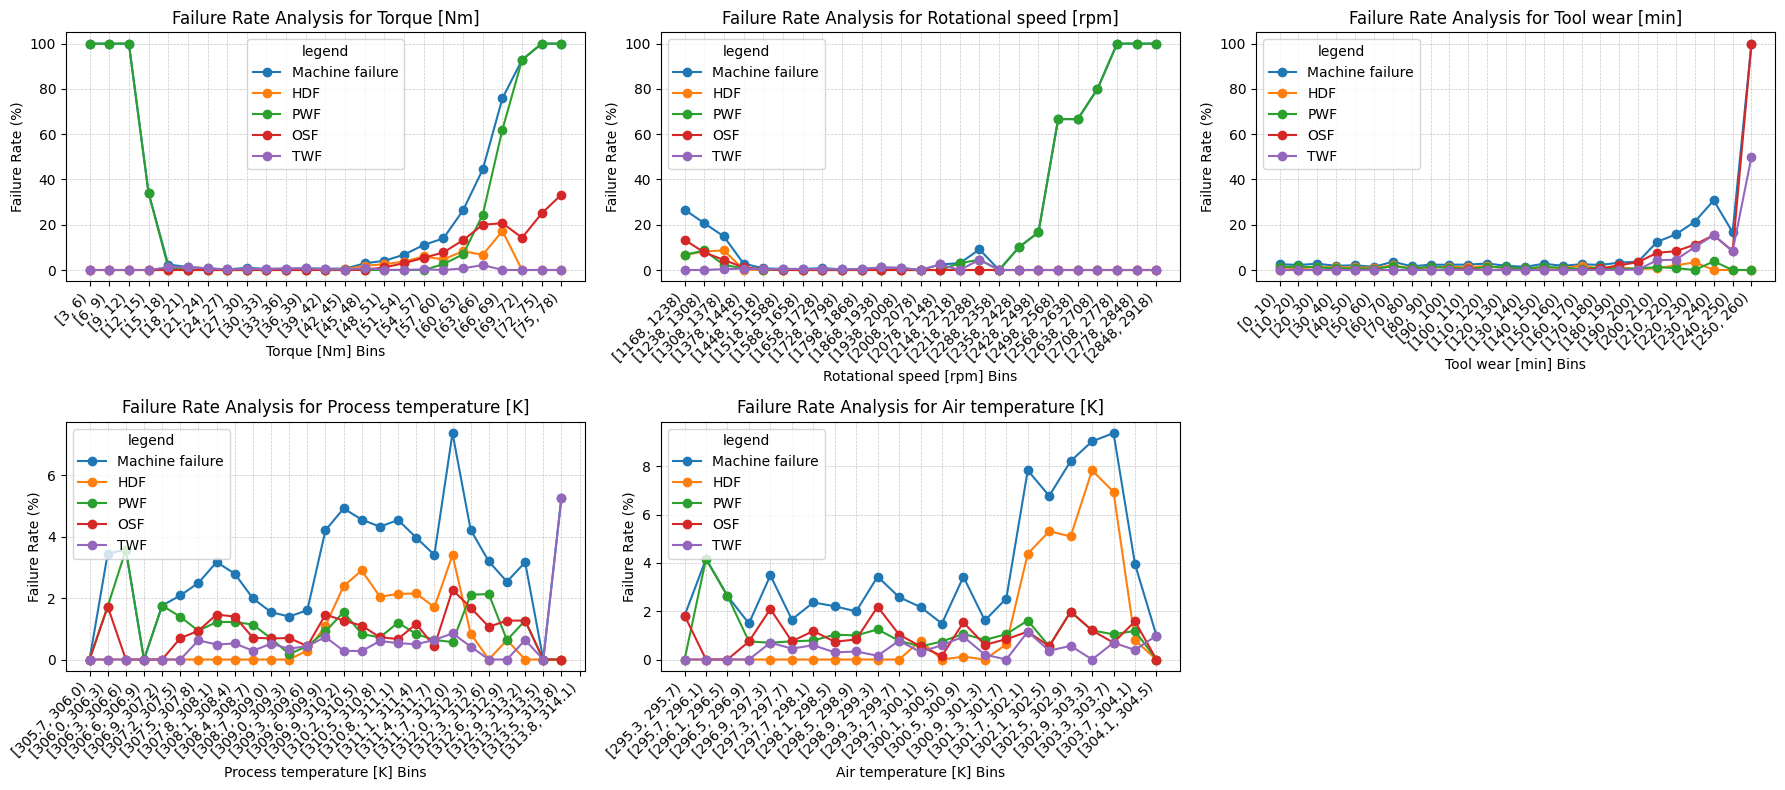

In [484]:
# Assuming Plotter class is instantiated with the data
machine_settings = ['Torque [Nm]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Process temperature [K]', 'Air temperature [K]']
failure_types = ['Machine failure', 'HDF', 'PWF', 'OSF', 'TWF']

plotter.failure_rate_analysis(plotter.dataframe,
                              selected_column=machine_settings,
                              target_column=failure_types)

In [226]:
# --------------- U N U S E D   M E T H O D S --------------- #

    def plot_tool_wear_by_quality(self):
        """Visualise tool wear distribution by product quality."""
        # TODO: Remove this method (unnecessary)
        plt.figure(figsize=(10, 6))

        # Define consistent bins for all product types
        bins = np.histogram_bin_edges(self.dataframe['Tool wear [min]'],
                                      bins=30)

        # Create a histogram for each product type
        for product_type, color in zip(['L', 'M', 'H'],
                                       ['blue', 'orange', 'green']):
            subset = self.dataframe[self.dataframe['Type'] == product_type]
            plt.hist(subset['Tool wear [min]'], bins=bins, alpha=0.5,
                     label=f'Type {product_type}', edgecolor='black')

        plt.title('Tool Wear Distribution by Product Quality')
        plt.xlabel('Tool wear [min]')
        plt.ylabel('Number of Tools')
        # Set x-axis ticks every 10 minutes
        plt.xticks(np.arange(0, 260, 10))  # Adjust range and step as needed
        # Set y-axis ticks every 50
        plt.yticks(np.arange(0, 500, 50))
        plt.legend(title='Product Quality Type')
        plt.tight_layout()
        plt.show()





Data range: 72.8
Initial bin width: 2.022222222222222

Data range: 1718
Initial bin width: 47.72222222222222

Rounded Torque data bin width: 2.0
Rounded Rotational data bin width: 50.0
